In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from string import punctuation
pd.options.display.max_colwidth = 200
%matplotlib inline

# Proprocessing corpus

In [ ]:

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')

In [3]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [4]:
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

Total lines: 30103

Sample line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


# Implementing the Continuous Bag of Words (CBOW) Model

In [5]:
# Build the corpus vocabulary
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index # word2id[word] = word_ID

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()} # id2word[word_ID] = word
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible] # all word IDs each line in Bible

vocab_size = len(word2id)
# context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocabulary Size: 12430
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('not', 4), ('thou', 5), ('thy', 6), ('god', 7), ('ye', 8), ('said', 9), ('thee', 10)]


In [6]:
word2id['adversary'],len(wids),len(word2id),len(id2word)

(2021, 29324, 12430, 12430)

Thus you can see that we have created a vocabulary of unique words in our corpus and also ways to map a word to its unique identifier and vice versa. The PAD term is typically used to pad context words to a fixed length if needed.

In [7]:
# Build a CBOW (context, target) generator
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size) # create vector for y in vocab_size dimension
            yield (x, y)

In [8]:
# Test this out for some samples. Note: corpus used wids

window_size = 2 
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['old', 'testament', 'james', 'bible'] -> Target (Y): king
Context (X): ['first', 'book', 'called', 'genesis'] -> Target (Y): moses
Context (X): ['beginning', 'god', 'heaven', 'earth'] -> Target (Y): created
Context (X): ['earth', 'without', 'void', 'darkness'] -> Target (Y): form
Context (X): ['without', 'form', 'darkness', 'upon'] -> Target (Y): void
Context (X): ['form', 'void', 'upon', 'face'] -> Target (Y): darkness
Context (X): ['void', 'darkness', 'face', 'deep'] -> Target (Y): upon
Context (X): ['spirit', 'god', 'upon', 'face'] -> Target (Y): moved
Context (X): ['god', 'moved', 'face', 'waters'] -> Target (Y): upon
Context (X): ['god', 'said', 'light', 'light'] -> Target (Y): let
Context (X): ['god', 'saw', 'good', 'god'] -> Target (Y): light


W1017 13:07:57.243593 4693624256 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1017 13:07:57.268365 4693624256 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1017 13:07:57.278004 4693624256 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1017 13:07:57.352172 4693624256 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1017 13:07:57.388638 4693624256 deprecation_wrapper.py:119] From //anac

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            1243000   
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12430)             1255430   
Total params: 2,498,430
Trainable params: 2,498,430
Non-trainable params: 0
_________________________________________________________________
None


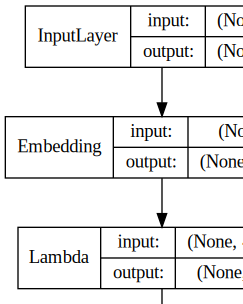

In [9]:
# Build the CBOW model architecture
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW architecture
embed_size = 100
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())


In [25]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

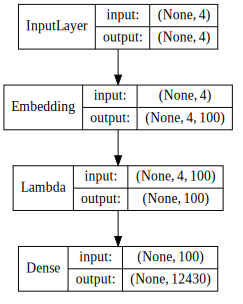

In [24]:
SVG(model_to_dot(cbow, dpi = 70, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [31]:
# training model
import datetime

for epoch in range(1, 6):
    print(datetime.datetime.now())
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

W1017 13:24:11.991053 4693624256 deprecation.py:323] From //anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-10-17 13:24:11.878731


W1017 13:24:12.103739 4693624256 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Processed 100000 (context, word) pairs
Processed 200000 (context, word) pairs
Processed 300000 (context, word) pairs
Epoch: 1 	Loss: 4036740.001077469

2019-10-17 16:01:06.266773


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

# Implementing the Continuous Skip-gram Model

In [ ]:
# generate the same wids,word2id,id2word as in CBOW model
from keras.preprocessing.sequence import skipgrams

# generate skip-grams: [(target, context), relevancy] generator
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

In [ ]:
# Build the skip-gram model architecture
from keras.layers import Merge
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential

# build skip-gram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

model = Sequential()
model.add(Merge([word_model, context_model], mode="dot"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

# view model summary
print(model.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
# train the model
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

In [ ]:

merge_layer = model.layers[0]
word_model = merge_layer.layers[0]
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}

similar_words

In [ ]:
# using t-SNE which stands for t-distributed stochastic neighbor embedding a popular
#  dimensionality reduction technique to visualize higher dimension spaces in lower dimensions (e.g. 2-D)
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
# Using gensim's word2vec 

from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
w2v_model.wv['sky']

In [ ]:
# One strategy would be to average out the word embeddings for each word in a document. 
# This is an extremely useful strategy and you can adopt the same for your own problems
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

In [ ]:
# Now that we have our features for each document, let’s cluster these documents using 
# the Affinity Propagation algorithm, which is a clustering algorithm based on 
# the concept of “message passing” between data points and does not need the number of clusters 
# as an explicit input which is often required by partition-based clustering algorithms

from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# The GloVe Model 

### training is performed on an aggregated global word-word co-occurrence matrix, giving us a vector space with meaningful sub-structures

In [52]:
!python -m spacy link en_core_web_md en_default



✘ Can't locate model data
The data should be located in en_core_web_md



In [53]:
# check vocabulary
import spacy

nlp = spacy.load('en_core_web_sm',parse=True, tag=True, entity=True)

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 0


In [ ]:
# get the word vectorizer
unique_words = list(set([word for sublist in [doc.split() for doc in norm_corpus] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

In [ ]:
# kMeans clustering
doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in norm_corpus])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# The FastText Model

In [ ]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)
                    
                    
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words        

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')


In [ ]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))